# Adaptive Bio-CCA demo

### Imports

In [16]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import time

from cca_algorithms import bio_cca, gen_oja, bio_rrr, asy_cca, adaptive_bio_cca
from util import subspace_error, correlation_matrix, add_fill_lines

### Load dataset

In [18]:
dataset = 'synthetic'
# dataset = 'mediamill'
# dataset = 'adaptive'

In [19]:
# load dataset

X, Y, samples = {}, {}, {}

if dataset=='synthetic':
    modes = ["A"]
    X["A"] = np.load('datasets/synthetic/view1.npy')
    Y["A"] = np.load('datasets/synthetic/view2.npy')
elif dataset=='mediamill':
    modes = ["A"]
    X["A"] = np.load('datasets/mediamill/view1.npy')
    Y["A"] = np.load('datasets/mediamill/view2.npy')
elif dataset=='adaptive':
    modes = ["A", "B", "C"]
    X["A"] = np.load('datasets/adaptive/view1a.npy')
    Y["A"] = np.load('datasets/adaptive/view2a.npy')
    X["B"] = np.load('datasets/adaptive/view1b.npy')
    Y["B"] = np.load('datasets/adaptive/view2b.npy')
    X["C"] = np.load('datasets/adaptive/view1c.npy')
    Y["C"] = np.load('datasets/adaptive/view2c.npy')

# dataset dimensions

x_dim = X["A"].shape[0]
y_dim = Y["A"].shape[0]

for mode in modes:
    samples[mode] = X[mode].shape[1]

### Offline solution

In [20]:
Cxx, Cyy, Cxy, Rxy, u, canonical_correlations, vh = {}, {}, {}, {}, {}, {}, {}

for mode in modes:
    Cxx[mode] = X[mode]@X[mode].T/samples[mode]
    Cyy[mode] = Y[mode]@Y[mode].T/samples[mode]
    Cxy[mode] = X[mode]@Y[mode].T/samples[mode]
    Rxy[mode] = correlation_matrix(Cxx[mode],Cyy[mode],Cxy[mode])
    u[mode], canonical_correlations[mode], vh[mode] = np.linalg.svd(Rxy[mode])

### Plot canonical correlations

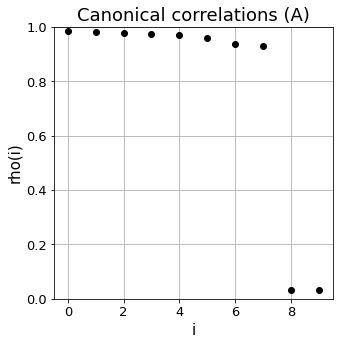

In [21]:
fig = plt.figure(figsize=(5*len(modes),5))

i = 1

for mode in modes:

    ax = plt.subplot(1, len(modes), i)

    ax.plot(canonical_correlations[mode], 'o', color='black')
    plt.xlim(-.5,9.5)
    plt.ylim(0,1)
    plt.title(f'Canonical correlations ({mode})')
    plt.xlabel('i')
    plt.ylabel('rho(i)')
    plt.grid()
    
    i += 1

plt.show()

### Online algorithms

In [33]:
# Parameters

trials = 1; z_dim = 4; alpha = 1.5

iters = 0

for mode in modes:
    iters += samples[mode]

In [34]:
r = {}

for mode in modes:
    r[mode] = min(sum(1 for i in canonical_correlations[mode] if 1+i>alpha),z_dim)

In [35]:
# Optimal subspace projections

Ux, Uy, Px_opt, Py_opt = {}, {}, {}, {}

for mode in modes:
    Ux[mode] = u[mode][:,:r[mode]]
    Uy[mode] = vh[mode].T[:,:r[mode]]

    Px_opt[mode] = Ux[mode]@Ux[mode].T
    Py_opt[mode] = Uy[mode]@Uy[mode].T

In [36]:
# Specify which algorithms to run

algorithms = []

algorithms.append('Adaptive Bio-CCA')
# algorithms.append('Bio-CCA')
# if z_dim==1: algorithms.append('Gen-Oja')
# algorithms.append('Asymmetric-CCA')
algorithms.append('Bio-RRR')

In [37]:
alg_subspacex_error = {}
alg_time = {}

for alg in algorithms:
    alg_time[alg] = np.zeros((trials,iters))
    alg_subspacex_error[alg] = np.zeros((trials,iters))

In [38]:
start_time = time.time()

for i_trial in range(trials):
    
    print(f'Trial {i_trial+1} out of {trials}:')
                
    # Initialize Bio-CCA
    
    if 'Adaptive Bio-CCA' in algorithms:
        adaptive = adaptive_bio_cca(z_dim,x_dim,y_dim,alpha,dataset)
        adaptive_Vx = np.zeros((iters,x_dim,z_dim))
        adaptive_Vy = np.zeros((iters,y_dim,z_dim))
    
    if 'Bio-CCA' in algorithms:
        biocca = bio_cca(z_dim,x_dim,y_dim,dataset)   
        biocca_Vx = np.zeros((iters,x_dim,z_dim))
        biocca_Vy = np.zeros((iters,y_dim,z_dim))
    
    # Initialize Asymmetric-CCA
        
    if 'Asymmetric-CCA' in algorithms:
        if dataset=='synthetic': asycca = CCAPyramidal(X,Y,k=z_dim,eta={"W":0.0002,"V":0.0002,"M":0.0002,"Lambda":0.0002,"Gamma":0.0002},steps=iters,alpha=5e-6,mode="hierarchy")
        elif dataset=='mediamill': asycca = CCAPyramidal(X,Y,k=z_dim,eta={"W":0.002,"V":0.002,"M":0.002,"Lambda":0.002,"Gamma":0.002},steps=iters,alpha=5e-6,mode="hierarchy")
            
        asycca_Vx = np.zeros((iters,x_dim,z_dim))
        asycca_Vy = np.zeros((iters,y_dim,z_dim))

    # Initialize Bio-RRR
        
    if 'Bio-RRR' in algorithms:
        biorrr = bio_rrr(z_dim,x_dim,y_dim,dataset)
        biorrr_Vx = np.zeros((iters,x_dim,z_dim))
        biorrr_Vy = np.zeros((iters,y_dim,z_dim))

    # Initialize Gen-Oja
    
    if 'Gen-Oja' in algorithms:
        genoja = gen_oja(x_dim,y_dim,dataset)
        genoja_vx = np.zeros((iters,x_dim,1))
        genoja_vy = np.zeros((iters,y_dim,1))
            
    # Run online algorithms
    
    print('Running online algorithms...')
    
    prev_iters = 0
    
    for mode in modes:
        
        print(f'Mode {mode}:')
        
        # Random permutation of the inputs

        idx = np.random.permutation(samples[mode])
    
        # Online updates

        for i_sample in range(samples[mode]):
            
            i_iter = prev_iters + i_sample

            x = X[mode][:,idx[i_sample]]
            y = Y[mode][:,idx[i_sample]]

            # online updates

            if 'Adaptive Bio-CCA' in algorithms:
                checkpoint = time.time()
                adaptive_Vx[i_iter], adaptive_Vy[i_iter] = adaptive.fit_next(x,y)
                alg_time['Adaptive Bio-CCA'][i_trial,i_iter] = alg_time['Adaptive Bio-CCA'][i_trial,max(i_iter-1,0)] + time.time() - checkpoint
            if 'Bio-CCA' in algorithms:
                checkpoint = time.time()
                biocca_Vx[i_iter], biocca_Vy[i_iter] = biocca.fit_next(x,y)
                alg_time['Bio-CCA'][i_trial,i_iter] = alg_time['Bio-CCA'][i_trial,max(i_iter-1,0)] + time.time() - checkpoint
            if 'Asymmetric-CCA' in algorithms: 
                checkpoint = time.time()
                asycca.online_step(idx[i_sample], asycca.decay(i_iter))
                asycca_Vx[i_iter], asycca_Vy[i_iter] = asycca.W, asycca.V
                alg_time['Asymmetric-CCA'][i_trial,i_iter] = alg_time['Asymmetric-CCA'][i_trial,max(i_iter-1,0)] + time.time() - checkpoint
            if 'Bio-RRR' in algorithms: 
                checkpoint = time.time()
                biorrr_Vx[i_iter], biorrr_Vy[i_iter] = biorrr.fit_next(x,y)
                alg_time['Bio-RRR'][i_trial,i_iter] = alg_time['Bio-RRR'][i_trial,max(i_iter-1,0)] + time.time() - checkpoint
            if 'Gen-Oja' in algorithms: 
                checkpoint = time.time()
                genoja_vx[i_iter], genoja_vy[i_iter] = genoja.fit_next(x,y)
                alg_time['Gen-Oja'][i_trial,i_iter] = alg_time['Gen-Oja'][i_trial,max(i_iter-1,0)] + time.time() - checkpoint
                
        print(f'Elapsed time: {time.time()-start_time} seconds')
        
        prev_iters+=samples[mode]
        
        # Compute error

        print('Computing errors...')

        for i_iter in range(iters):
            if 'Adaptive Bio-CCA' in algorithms:
                ux, sx, vxh = np.linalg.svd(adaptive_Vx[i_iter])
                alg_subspacex_error['Adaptive Bio-CCA'][i_trial,i_iter] = subspace_error(ux[:,:r[mode]], Px_opt[mode])
            if 'Bio-CCA' in algorithms: 
                alg_subspacex_error['Bio-CCA'][i_trial,i_iter] = subspace_error(biocca_Vx[i_iter], Px_opt[mode])
            if 'Asymmetric-CCA' in algorithms: 
                alg_subspacex_error['Asymmetric-CCA'][i_trial,i_iter] = subspace_error(asycca_Vx[i_iter], Px_opt[mode])
            if 'Bio-RRR' in algorithms:
                ux, sx, vxh = np.linalg.svd(biorrr_Vx[i_iter])
                alg_subspacex_error['Bio-RRR'][i_trial,i_iter] = subspace_error(ux[:,:r[mode]], Px_opt[mode])
            if 'Gen-Oja' in algorithms: 
                alg_subspacex_error['Gen-Oja'][i_trial,i_iter] = subspace_error(genoja_vx[i_iter], Px_opt[mode])
            
# save data 
            
pkl.dump(alg_subspacex_error, open(f'error/{dataset}_{z_dim}-dim_subspacex_error.p', 'wb'))
pkl.dump(alg_time, open(f'error/{dataset}_{z_dim}-dim_time.p', 'wb'))

print('Trials complete')

Trial 1 out of 1:
Running online algorithms...
Mode A:
Elapsed time: 10.706503868103027 seconds
Computing errors...
Trials complete


### Plots

In [39]:
font = {'weight' : 'normal', 'size' : 15}

plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13) 

plt.rc('font', **font)

In [40]:
colors = {}

colors['Adaptive Bio-CCA'] = 'tab:blue'
colors['Gen-Oja'] = 'tab:green'
colors['Asymmetric-CCA'] = 'tab:red'
colors['Bio-RRR'] = 'tab:purple'

##### Per iterate comparison (subspace error)

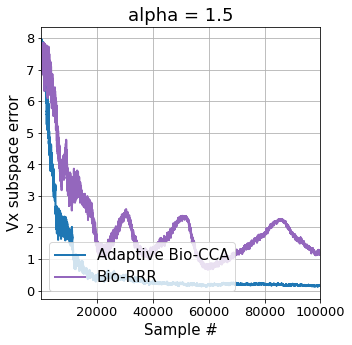

In [43]:
alg_subspacex_error = pkl.load(open(f'error/{dataset}_{z_dim}-dim_subspacex_error.p', 'rb'))

linewidth = 2

t = list(range(iters))

fig = plt.figure(figsize=(5,5))

ax = plt.subplot(1, 1, 1)

for alg in algorithms:
    add_fill_lines(ax, t, alg_subspacex_error[alg], plot_kwargs={'ls': '-', 'lw': linewidth, 'label': alg, 'color': colors[alg]}, ci_kwargs={'color': colors[alg]})

ax.plot()

plt.title(f"alpha = {alpha}")
plt.grid()
plt.legend(loc = 'lower left')
plt.xlim((1e2,iters))
plt.xlabel('Sample #')
plt.ylabel('Vx subspace error')

plt.show()
# plt.savefig(f'plots/{dataset}_{z_dim}-dim_subspacex_iterate.png', dpi=300, transparent='true', bbox_inches='tight')

##### Runtime comparison

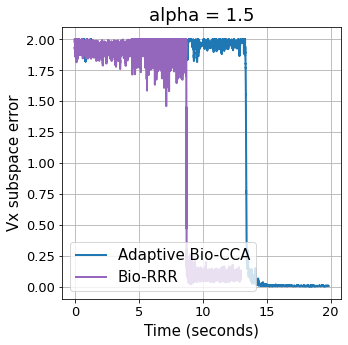

In [15]:
alg_subspacex_error = pkl.load(open(f'error/{dataset}_{z_dim}-dim_subspacex_error.p', 'rb'))
alg_time = pkl.load(open(f'error/{dataset}_{z_dim}-dim_time.p', 'rb'))

linewidth = 2

fig = plt.figure(figsize=(5,5))

ax = plt.subplot(1, 1, 1)

for alg in algorithms:
    if alg!='MSG-CCA':
        add_fill_lines(ax, np.mean(alg_time[alg],axis=0), alg_subspacex_error[alg], plot_kwargs={'ls': '-', 'lw': linewidth, 'label': alg, 'color': colors[alg]}, ci_kwargs={'color': colors[alg]})

ax.plot()

plt.title(f"alpha = {alpha}")
plt.grid()
plt.legend(loc = 'lower left')
plt.xlabel('Time (seconds)')
plt.ylabel('Vx subspace error')

plt.show()
# plt.savefig(f'plots/{dataset}_{z_dim}-dim_subspacex_runtime.png', dpi=300, transparent='true', bbox_inches='tight')